## **Set up the environment**

In [1]:
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np 
import pandas as pd
import time, os
import warnings
warnings.simplefilter('ignore')

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### **Access Dataset**

In [2]:
os.environ['KAGGLE_USERNAME'] = "kingalagbe"
os.environ['KAGGLE_KEY'] = "9d829fe67ac875f5eda3761e81b3811e"

!kaggle datasets download -d welcomehere/restoringdiacritics2

 96%|███████████████████████████████████████▍ | 265M/276M [00:02<00:00, 133MB/s]
100%|█████████████████████████████████████████| 276M/276M [00:02<00:00, 106MB/s]


### **Extract the dataset**

In [3]:
#Extraction process

#1.0
from zipfile import ZipFile

#2.0
file_name = "./restoringdiacritics2.zip"

#3.0
with ZipFile(file_name, 'r') as Zip: 
  #zip.printdir()
  lst = Zip.namelist()
  
  #3.1
  print('Extracting all the files now...') 
  tick = time.time()
  Zip.extractall()
  tock = time.time()
  print(f'Done!\n{round((tock-tick),2)} seconds...')

Extracting all the files now...
Done!
12.2 seconds...


In [4]:
os.remove('./restoringdiacritics2.zip')

In [5]:
path = "./"
train_rows = 1_000
test_rows = 1_000

train = pd.read_csv(path + "new_train.csv", nrows = train_rows)
test = pd.read_csv(path + "new_test.csv", nrows = test_rows)

In [6]:
train.tail()

,labels,feature
995,\t jésù kórìíra ìwà ta ni yóò mú mi àti ìw...,jesu koriira iwa ta ni yoo mu mi ati iwa i...
996,\t bí òtítọ́ bíbélì ṣe ń sọni dòmìnira : bíbél...,bi otito bibeli se n soni dominira : bibeli so...
997,\t ò tún tẹ òru àti ẹ̀sán lérí ba \n,o tun te oru ati esan leri ba
998,\t abrahamu àti sara sì ti di arúgbó: sara sì ...,abrahamu ati sara si ti di arugbo: sara si ti ...
999,\t ṣugbọn ẹ̀yin arakunrin miẹlẹ́tàn ni yín bíi...,sugbon eyin arakunrin mieletan ni yin bii odo ...


### **Trigram generator**

In [7]:
copy = train.copy()

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
F, L = [], []
for sentence in zip(copy['labels'].str.replace('\t ', '').str.replace(' \n', '').values, copy['feature'].str.replace('\t ', '').str.replace(' \n', '').values):
    tokensL, tokensF = nltk.word_tokenize(sentence[0]), nltk.word_tokenize(sentence[1])
    for text in zip(tokensL, tokensF): 
        L.append(text[0])
        F.append(text[1])
        #break

In [10]:
blockL = []
blockF = []
l, r = 0, 3
for i in range(len(L)//3): 
    blockL.append(f"\t {' '.join(L[l:r])} \n")
    blockF.append(' '.join(F[l:r]))
    r += 3
    l += 3

In [11]:
temp_df = pd.DataFrame(blockL, columns = ['labels'])
temp_df['feature'] = blockF
temp_df.head(10)

,labels,feature
0,\t lẹ́yìn tí wọ́n \n,leyin ti won
1,\t ṣègbéyàwó aya náà \n,segbeyawo aya naa
2,\t sọ pé ẹ̀rí \n,so pe eri
3,\t ọkàn òun ń \n,okan oun n
4,\t da òun láàmú \n,da oun laamu
5,\t kódà ó ba \n,koda o ba
6,\t ayọ̀ ọjọ́ ìgbéyàwó \n,ayo ojo igbeyawo
7,\t rẹ̀ jẹ́ wọ̀nyí \n,re je wonyi
8,\t ni nwọ́n níláti \n,ni nwon nilati
9,\t pamọ́ ní mímọ́ \n,pamo ni mimo


In [12]:
# Number of Rows
len(temp_df)

5727

In [13]:
# Replacing the train DataFrame with the temporary (temp) DataFrame
train = temp_df
train_rows = len(temp_df)
#test_rows = 1_000

In [14]:
#from nltk.tokenize import word_tokenize
#train_token = train.feature.apply(word_tokenize)

In [15]:
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

In [16]:
n = train.feature.tolist()
input_texts.append(n)

In [17]:
m = train.labels.tolist()
target_texts.append(m)

In [18]:
for char in n:
        if char not in input_chars:
            input_chars.add(char)
for char in m:
        if char not in target_chars:
            target_chars.add(char)

In [19]:
input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])


In [20]:
#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 1
Number of unique input tokens: 5511
Number of unique output tokens: 5545
Max sequence length for inputs: 5727
Max sequence length for outputs: 5727


In [21]:
#Define data for encoder and decoder
input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_in_data[i, t, input_token_id[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_in_data[i, t, target_token_id[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_id[char]] = 1.

In [22]:
#Hyperparameters
batch_size = 64
latent_dim = 256
num_samples = 10000

import tensorflow as tf

In [23]:
# Define an input sequence and process it.
encoder_inputs = tf.keras.layers.Input(shape=(None, num_encoder_tokens))
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = tf.keras.layers.Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model that will turn
# encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Define your optimizer
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

#Compiling and training the model
model.compile(optimizer=Adam , loss='categorical_crossentropy', metrics = ['categorical_accuracy'])
 

2022-01-23 06:37:52.051566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 06:37:52.181020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 06:37:52.181753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-23 06:37:52.183757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 5511)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 5545)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 5906432     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  5941248     input_2[0][0]                    
                                                                 lstm[0][1]                   

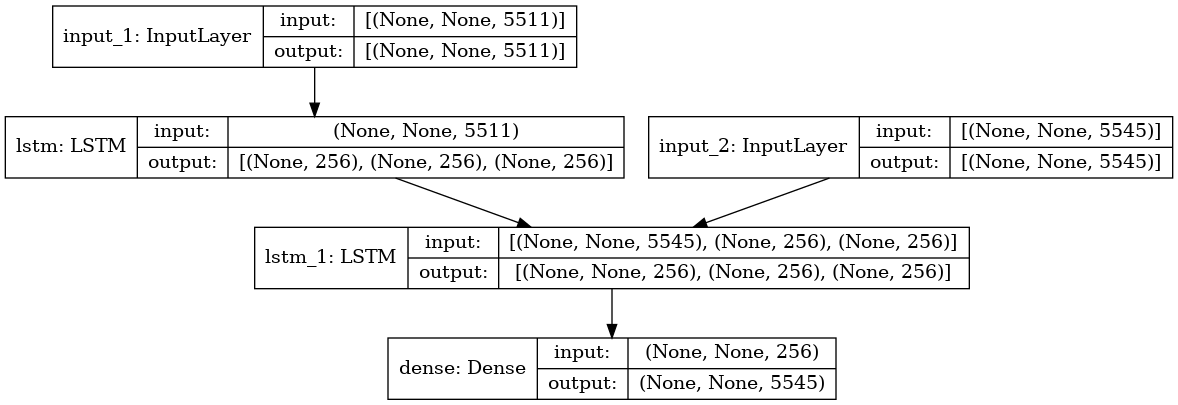

In [24]:

model.summary()

#Visuaize the model
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [25]:
# Split the training dataset in train and val data
lim = int(0.8 * train_rows)
dec_lim = int(0.8 * decoder_target_data.shape[1])


encoder_in_dataT, encoder_in_dataV = encoder_in_data[:, :lim, :], encoder_in_data[:, lim: , :]
decoder_in_dataT, decoder_in_dataV = decoder_in_data[:, :lim, :], decoder_in_data[:, lim: , :]
decoder_target_dataT, decoder_target_dataV = decoder_target_data[:, :dec_lim, :], decoder_target_data[:, dec_lim: , :]

In [26]:
#Model data Shape
print("encoder_in_data shape:", encoder_in_dataT.shape, encoder_in_dataV.shape)
print("decoder_in_data shape:", decoder_in_dataT.shape, decoder_in_dataV.shape)
print("decoder_target_data shape:", decoder_target_dataT.shape, decoder_target_dataV.shape)

encoder_in_data shape: (1, 4581, 5511) (1, 1146, 5511)
decoder_in_data shape: (1, 4581, 5545) (1, 1146, 5545)
decoder_target_data shape: (1, 4581, 5545) (1, 1146, 5545)


In [27]:
history = model.fit([encoder_in_dataT, decoder_in_dataT],
          decoder_target_dataT,
          batch_size = batch_size,
          #validation_data = ([encoder_in_dataV, decoder_in_dataV], decoder_target_dataV),
          epochs = 100)

2022-01-23 06:37:57.005080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-23 06:38:00.717714: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 5s 5s/step - loss: 8.6206 - categorical_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 1s 526ms/step - loss: 8.6062 - categorical_accuracy: 0.0692
Epoch 3/100
1/1 [==============================] - 1s 532ms/step - loss: 8.5789 - categorical_accuracy: 0.0020
Epoch 4/100
1/1 [==============================] - 1s 543ms/step - loss: 8.4602 - categorical_accuracy: 0.0013
Epoch 5/100
1/1 [==============================] - 1s 560ms/step - loss: 8.8482 - categorical_accuracy: 2.1829e-04
Epoch 6/100
1/1 [==============================] - 1s 533ms/step - loss: 8.7611 - categorical_accuracy: 0.0013
Epoch 7/100
1/1 [==============================] - 1s 548ms/step - loss: 8.4656 - categorical_accuracy: 8.7317e-04
Epoch 8/100
1/1 [==============================] - 1s 518ms/step - loss: 8.4795 - categorical_accuracy: 8.7317e-04
Epoch 9/100
1/1 [==============================] - 0s 483ms/step - loss: 8.4350 - categorical_accuracy: 0.0020


In [28]:
model.evaluate([encoder_in_data, decoder_in_data], decoder_target_data)

1/1 [==============================] - 1s 1s/step - loss: 3.3744 - categorical_accuracy: 0.7999


[3.3743512630462646, 0.7998952269554138]

In [29]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy'])

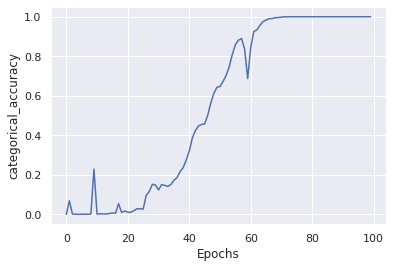

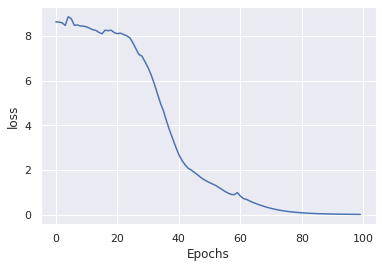

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  #plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  #plt.legend([string, 'val_'+string])
  plt.show()
  

sns.set_theme()
plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "loss")

In [31]:
#Define sampling models
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

In [32]:


#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Get the first character of target sequence with the start character.
    for i in target_token_id:
        if i == '\t':
            k = i
            target_seq[0, 0, k] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence

In [33]:
for seq_index in range(1):
    input_seq = encoder_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index][1:10])
    print("Decoded sentence: [", end = "")
    for i in decoded_sentence.split('\n')[:10]: print("'" + i.strip(' \t'), end = "', ")
    print(']')

-
Input sentence: ['segbeyawo aya naa', 'so pe eri', 'okan oun n', 'da oun laamu', 'koda o ba', 'ayo ojo igbeyawo', 're je wonyi', 'ni nwon nilati', 'pamo ni mimo']
Decoded sentence: ['ṣègbéyàwó aya náà', 'sọ pé ẹ̀rí', 'ọkàn òun ń', 'da òun láàmú', 'kódà ó ba', 'ayọ̀ ọjọ́ ìgbéyàwó', 'rẹ̀ jẹ́ wọ̀nyí', 'ni nwọ́n níláti', 'pamọ́ ní mímọ́', 'tí a sì', ]
